In [62]:
import tensorflow as tf
import numpy as np
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import matplotlib.patches as patches
from tensorflow.keras.utils import plot_model

In [2]:
def read_image_tfds(image, label):
  xmin = tf.random.uniform((), 0, 48, dtype=tf.int32)
  ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)
  image = tf.reshape(image, (28, 28, 1))
  image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
  image = tf.cast(image, tf.float32) / 255.0
  xmin = tf.cast(xmin, tf.float32)
  ymin = tf.cast(ymin, tf.float32)
  xmax = (xmin + 28) / 75
  ymax = (ymin + 28) / 75
  xmin /= 75
  ymin /= 75

  return image, (tf.one_hot(label, 10)), [xmin, ymin, xmax, ymax]

In [3]:
BATCH_SIZE = 64
train = tfds.load('mnist', split="train", as_supervised=True)
train_dataset = train.map(read_image_tfds, num_parallel_calls=16).shuffle(1024, reshuffle_each_iteration=True).batch(64).prefetch(tf.data.AUTOTUNE)

valid = tfds.load('mnist', split='test', as_supervised=True)
valid_dataset = valid.map(read_image_tfds, num_parallel_calls=16).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [34]:
sample = next(iter(train_dataset))
box = sample[2][0]*75

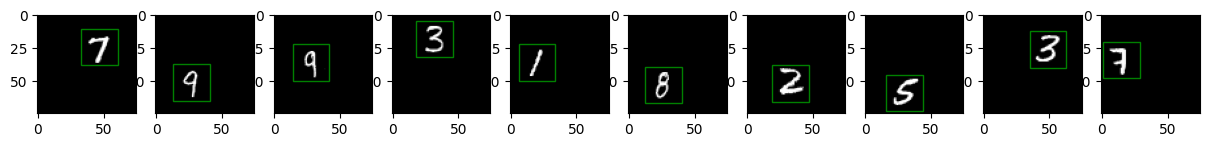

In [58]:
fig, ax = plt.subplots(1, 10, figsize=(15, 7))
for a, img, box in zip(ax, sample[0], sample[2]):
  box = box * 75
  width = box[2] - box[0]
  height = box[3] - box[1]
  a.imshow(img, cmap="gray")
  rect = patches.Rectangle((box[0], box[1]), width, height, linewidth=1, edgecolor='g', facecolor="none")
  a.add_patch(rect)


In [66]:
inputs = tf.keras.layers.Input(shape=(75, 75, 1))
x = tf.keras.layers.Conv2D(16, kernel_size=3, activation="relu")(inputs)
x = tf.keras.layers.AveragePooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.AveragePooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.AveragePooling2D((2, 2))(x)

flat = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(128, activation="relu")(flat)

clf_output = tf.keras.layers.Dense(10, activation="softmax", name="classifier")(dense)
box_output = tf.keras.layers.Dense(4, name="bounding_box")(dense)

model = tf.keras.Model(inputs=inputs, outputs=[clf_output, box_output])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 73, 73, 16)           160       ['input_3[0][0]']             
                                                                                                  
 average_pooling2d_14 (Aver  (None, 36, 36, 16)           0         ['conv2d_15[0][0]']           
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_16 (Conv2D)          (None, 34, 34, 32)           4640      ['average_pooling2d_14[0

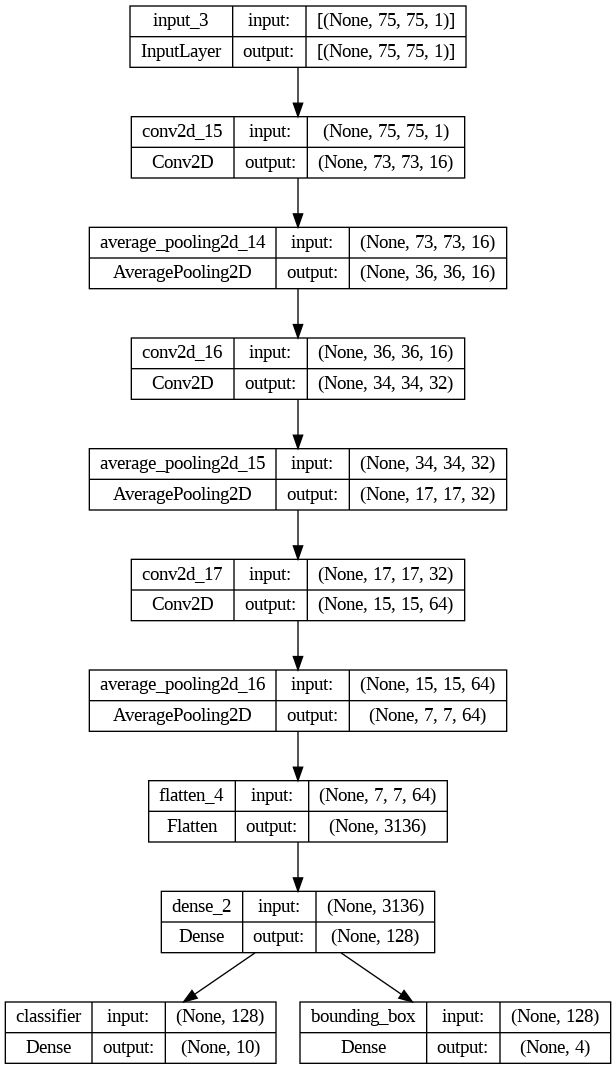

In [68]:
plot_model(model, show_shapes=True)